In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

from math import sqrt

plt.rcParams['font.size'] = 12


# Dataset “Babyboom”

- Проверьте вес младенцев на нормальность (все данные, затем по полу: девочки/мальчики). Используйте точечные оценки параметров. Постройте доверительные интервалы для μ и σ нормального распределения.
- Проверьте гипотезу: интервалы между рождениями ~ Exponential (оценка λ = 1/mean).
- Проверьте гипотезу: число рождений в час ~ Poisson(λ = mean per hour).

In [2]:
babyboomDataFrame = pd.read_csv(
    '../datasets/babyboom.dat.txt',
    sep='\s+',
    header=None,
    names=['timeOfBirth24', 'sexCode', 'birthWeightGrams', 'minutesAfterMidnight']
)

babyboomDataFrame['sexCode'] = babyboomDataFrame['sexCode'].astype(int)
babyboomDataFrame['birthWeightGrams'] = pd.to_numeric(babyboomDataFrame['birthWeightGrams'], errors='coerce')
babyboomDataFrame['minutesAfterMidnight'] = pd.to_numeric(babyboomDataFrame['minutesAfterMidnight'], errors='coerce')

print('Размер выборки babyboom:', len(babyboomDataFrame))
babyboomDataFrame.head()


Размер выборки babyboom: 44


,timeOfBirth24,sexCode,birthWeightGrams,minutesAfterMidnight
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


## Доверительные интервалы

In [3]:
def confidenceIntervalForMean(sampleSeries, confidenceLevel=0.95):
    n = sampleSeries.size
    meanValue = sampleSeries.mean()
    sdValue = sampleSeries.std(ddof=1)
    alpha = 1 - confidenceLevel
    tCritical = sps.t.ppf(1 - alpha/2, df=n-1)
    marginError = tCritical * sdValue / sqrt(n)
    return meanValue - marginError, meanValue + marginError

def confidenceIntervalForSigma(sampleSeries, confidenceLevel=0.95):
    # CI для σ при нормальности через хи-квадрат
    n = sampleSeries.size
    sampleVariance = sampleSeries.var(ddof=1)
    alpha = 1 - confidenceLevel
    chi2Lower = sps.chi2.ppf(alpha/2, df=n-1)
    chi2Upper = sps.chi2.ppf(1 - alpha/2, df=n-1)
    lowerSigma = sqrt((n-1) * sampleVariance / chi2Upper)
    upperSigma = sqrt((n-1) * sampleVariance / chi2Lower)
    return lowerSigma, upperSigma

## Проверка нормальности веса (вся выборка и по полу)

N = 44
Среднее (точечная оценка): 3275.9545454545455
Выборочная дисперсия (точечная оценка): 278818.27695560263
Выборочное SD: 528.0324582405921

Shapiro-Wilk: statistic = 0.8987 , p-value = 0.000994

Anderson-Darling statistic = 1.7168
Критические значения: [0.534 0.609 0.73  0.852 1.013]
Соответствующие уровни: [15.  10.   5.   2.5  1. ]

Kolmogorov-Smirnov (fitted): statistic = 0.1834 , p-value = 0.091065


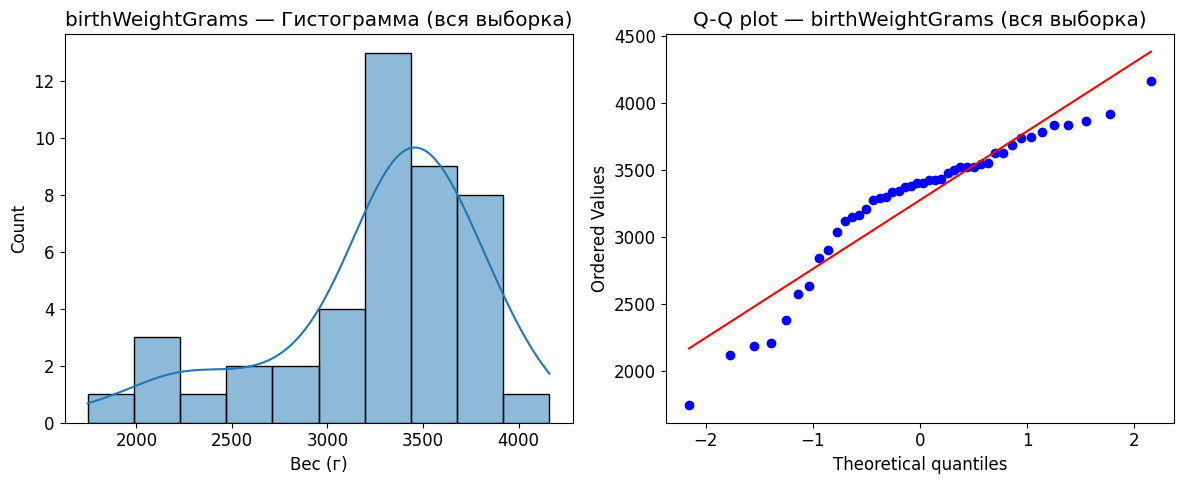

In [4]:
birthWeightSeries = babyboomDataFrame['birthWeightGrams'].dropna()
nSample = birthWeightSeries.size
meanWeight = birthWeightSeries.mean()
varWeight = birthWeightSeries.var(ddof=1)
sdWeight = birthWeightSeries.std(ddof=1)

print('N =', nSample)
print('Среднее (точечная оценка):', meanWeight)
print('Выборочная дисперсия (точечная оценка):', varWeight)
print('Выборочное SD:', sdWeight)

# Шапиро-Уилк
shapiroStatistic, shapiroPvalue = sps.shapiro(birthWeightSeries)
print('\nShapiro-Wilk: statistic =', round(shapiroStatistic,4), ', p-value =', round(shapiroPvalue,6))

# Anderson-Darling
andersonResult = sps.anderson(birthWeightSeries, dist='norm')
print('\nAnderson-Darling statistic =', round(andersonResult.statistic,4))
print('Критические значения:', andersonResult.critical_values)
print('Соответствующие уровни:', andersonResult.significance_level)

# KS тест
ksStatistic, ksPvalue = sps.kstest(birthWeightSeries, 'norm', args=(meanWeight, sdWeight))
print('\nKolmogorov-Smirnov (fitted): statistic =', round(ksStatistic,4), ', p-value =', round(ksPvalue,6))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма
sns.histplot(birthWeightSeries, kde=True, ax=axes[0])
axes[0].set_title('birthWeightGrams — Гистограмма (вся выборка)')
axes[0].set_xlabel('Вес (г)')

# Q-Q
sps.probplot(birthWeightSeries, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q plot — birthWeightGrams (вся выборка)')

plt.tight_layout()
plt.show()

---- Girls ----
N = 18 Mean = 3132.4444444444443 SD = 631.582533586883
Shapiro-Wilk: statistic = 0.8703 , p-value = 0.017985
KS (with fitted mean/sd): statistic = 0.2143 , p-value = 0.331584
CI mean = (2818.3658395570424, 3446.5230493318463)
CI sigma = (473.93169852283967, 946.8331595131432)

---- Boys ----
N = 26 Mean = 3375.3076923076924 SD = 428.0460507217203
Shapiro-Wilk: statistic = 0.9475 , p-value = 0.202248
KS (with fitted mean/sd): statistic = 0.1554 , p-value = 0.507076
CI mean = (3202.4161508132743, 3548.1992338021105)
CI sigma = (335.69825689250627, 590.878537222306)



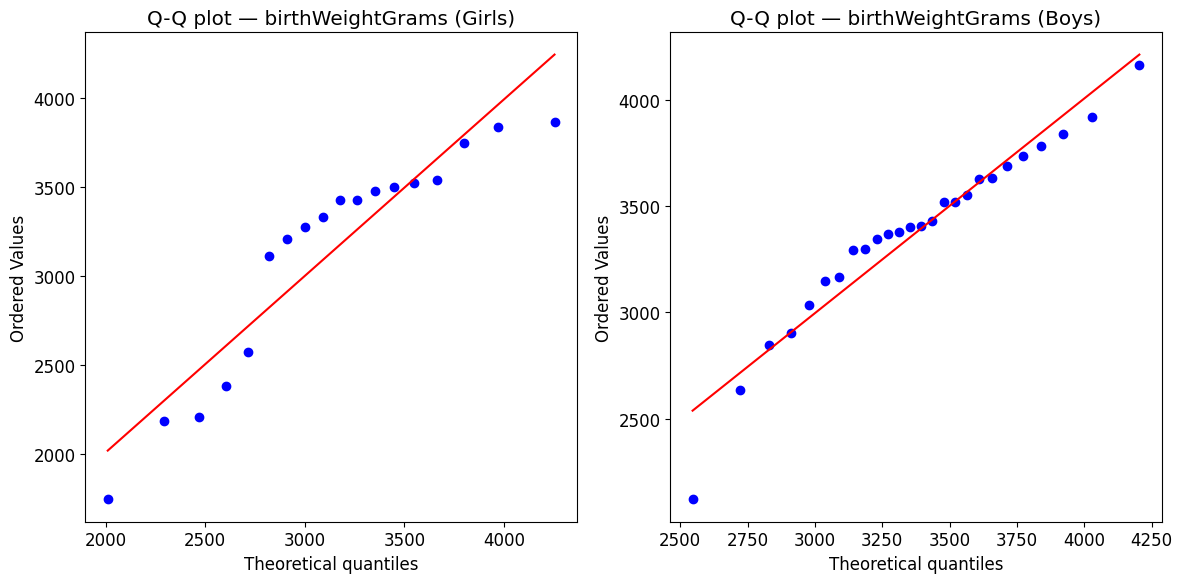

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, (sexCode, sexLabel) in enumerate([(1, 'Girls'), (2, 'Boys')]):
    subsetSeries = babyboomDataFrame.loc[babyboomDataFrame['sexCode']==sexCode, 'birthWeightGrams'].dropna()
    nSubset = subsetSeries.size
    meanSubset = subsetSeries.mean()
    sdSubset = subsetSeries.std(ddof=1)
    print('----', sexLabel, '----')
    print('N =', nSubset, 'Mean =', meanSubset, 'SD =', sdSubset)
    
    # Shapiro
    shapiroStatisticSub, shapiroPvalueSub = sps.shapiro(subsetSeries)
    print('Shapiro-Wilk: statistic =', round(shapiroStatisticSub,4), ', p-value =', round(shapiroPvalueSub,6))
    
    # KS с параметрами
    ksStatisticSub, ksPvalueSub = sps.kstest(subsetSeries, 'norm', args=(meanSubset, sdSubset))
    print('KS (with fitted mean/sd): statistic =', round(ksStatisticSub,4), ', p-value =', round(ksPvalueSub,6))
    
    print('CI mean =', confidenceIntervalForMean(subsetSeries, 0.95))
    print('CI sigma =', confidenceIntervalForSigma(subsetSeries, 0.95))
    print()
    
    # Q-Q plot на i-й оси
    sps.probplot(subsetSeries, dist='norm', sparams=(meanSubset, sdSubset), plot=axes[i])
    axes[i].set_title(f'Q-Q plot — birthWeightGrams ({sexLabel})')

plt.tight_layout()
plt.show()

## Доверительные интервалы для μ и σ (вся выборка и по полу)

In [6]:
print('=== Вся выборка ===')
print('CI mean (95%):', confidenceIntervalForMean(birthWeightSeries, 0.95))
print('CI sigma (95%):', confidenceIntervalForSigma(birthWeightSeries, 0.95))

for sexCode, sexLabel in [(1,'Girls'), (2,'Boys')]:
    subsetSeries = babyboomDataFrame.loc[babyboomDataFrame['sexCode']==sexCode, 'birthWeightGrams'].dropna()
    print(f'\n=== {sexLabel} ===')
    print('CI mean (95%):', confidenceIntervalForMean(subsetSeries, 0.95))
    print('CI sigma (95%):', confidenceIntervalForSigma(subsetSeries, 0.95))

=== Вся выборка ===
CI mean (95%): (3115.418005028038, 3436.491085881053)
CI sigma (95%): (436.27247886430507, 669.0306102925874)

=== Girls ===
CI mean (95%): (2818.3658395570424, 3446.5230493318463)
CI sigma (95%): (473.93169852283967, 946.8331595131432)

=== Boys ===
CI mean (95%): (3202.4161508132743, 3548.1992338021105)
CI sigma (95%): (335.69825689250627, 590.878537222306)


## Проверка Exponential для интервалов между рождениями

N intervals = 43
Mean interval (мин): 33.25581395348837
MLE lambda (1/mean): 0.03006993006993007
KS test vs Exponential(loc=0, scale=meanInterval): statistic = 0.1375 , p-value = 0.357427


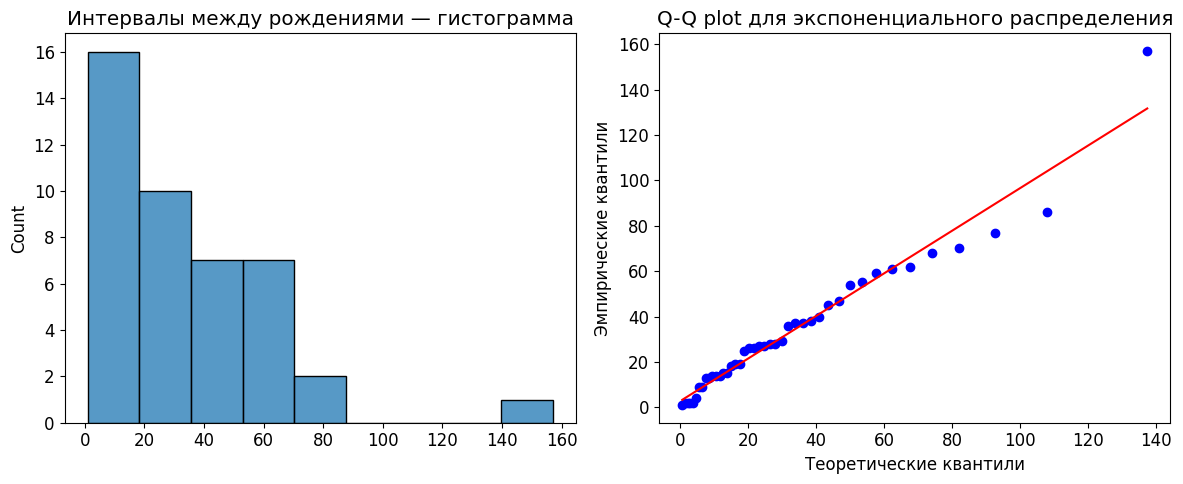

In [7]:
# Вычислим интервалы между рождениями (в минутах)
sortedMinutes = babyboomDataFrame['minutesAfterMidnight'].dropna().sort_values().values
intervalsBetweenBirths = np.diff(sortedMinutes)
intervalsBetweenBirths = intervalsBetweenBirths[intervalsBetweenBirths > 0]
nIntervals = intervalsBetweenBirths.size
meanInterval = intervalsBetweenBirths.mean()
lambdaEstimate = 1.0 / meanInterval if meanInterval > 0 else np.nan

print('N intervals =', nIntervals)
print('Mean interval (мин):', meanInterval)
print('MLE lambda (1/mean):', lambdaEstimate)

# KS test: сравним данные с экспоненциальным с scale=meanInterval (loc=0)
ksStatisticExp, ksPvalueExp = sps.kstest(intervalsBetweenBirths, 'expon', args=(0, meanInterval))
print('KS test vs Exponential(loc=0, scale=meanInterval): statistic =', round(ksStatisticExp,4), ', p-value =', round(ksPvalueExp,6))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма на первом подграфике
sns.histplot(intervalsBetweenBirths, kde=False, ax=axes[0])
axes[0].set_title('Интервалы между рождениями — гистограмма')

# Q-Q plot
sps.probplot(intervalsBetweenBirths, dist='expon', sparams=(0, meanInterval), plot=axes[1])
axes[1].set_title('Q-Q plot для экспоненциального распределения')
axes[1].set_xlabel('Теоретические квантили')
axes[1].set_ylabel('Эмпирические квантили')

plt.tight_layout()
plt.show()


## Проверка Poisson для числа рождений в час

In [8]:
# Подсчёт числа рождений по часам
minutesSeries = babyboomDataFrame['minutesAfterMidnight'].dropna().astype(int)
hoursSeries = (minutesSeries // 60) % 24
countsByHour = hoursSeries.value_counts().sort_index().reindex(range(24), fill_value=0)

# Распределение количества рождений в час: для k=0,1,2,...
countsOfCounts = pd.Series(countsByHour.values).value_counts().sort_index()
meanPerHour = countsByHour.mean()
lambdaPoisson = meanPerHour

# χ²: observed и expected frequencies
maxObserved = int(countsOfCounts.index.max())
observed = np.array([countsOfCounts.get(k, 0) for k in range(maxObserved + 1)])
expectedProbs = np.array([sps.poisson.pmf(k, mu=lambdaPoisson) for k in range(len(observed))])
expected = expectedProbs * 24  # 24 часа

# Нормализация суммы (чтобы expected.sum() == 24)
expected *= 24 / expected.sum()

# χ²-тест (ddof=1 за оценку λ)
chi2Statistic, chi2Pvalue = sps.chisquare(f_obs=observed, f_exp=expected, ddof=1)
print('Chi-square statistic =', chi2Statistic, ', p-value =', chi2Pvalue)

ksStatisticInformal, ksPvalueInformal = sps.kstest(countsByHour.values, 'poisson', args=(lambdaPoisson,))
print('Informal KS statistic =', ksStatisticInformal, ', p-value =', ksPvalueInformal)

Chi-square statistic = 1.055835623955893 , p-value = 0.7877447849877339
Informal KS statistic = 0.3279926138924665 , p-value = 0.00843012360162776


# Dataset “Euroweight”

- Проверьте нормальность веса монет (вся выборка, затем по batch). Используйте точечные оценки параметров.
- Постройте доверительные интервалы для μ и σ.

In [9]:
euroweightDataFrame = pd.read_csv('../datasets/euroweight.dat.txt', sep='\s+', header=None, names=['index', 'weight', 'batch'])
euroweightDataFrame['weight'] = pd.to_numeric(euroweightDataFrame['weight'], errors='coerce')
euroweightDataFrame['batch'] = euroweightDataFrame['batch'].astype(int)
print('Размер euroweight:', len(euroweightDataFrame))
euroweightDataFrame.head()

Размер euroweight: 2000


,index,weight,batch
0,1,7.512,1
1,2,7.502,1
2,3,7.461,1
3,4,7.562,1
4,5,7.528,1



=== Все монеты вместе ===
N = 2000 Mean = 7.5212325 SD = 0.03437914202613595
Shapiro-Wilk: statistic = 0.9755 , p-value = 0.0
KS (fitted): statistic = 0.0234 , p-value = 0.221925 

Доверительные интервалы (95%) для всех монет:
CI mean = (7.519724882523983, 7.522740117476017)
CI sigma = (0.03334580812823817, 0.03547904750143223)


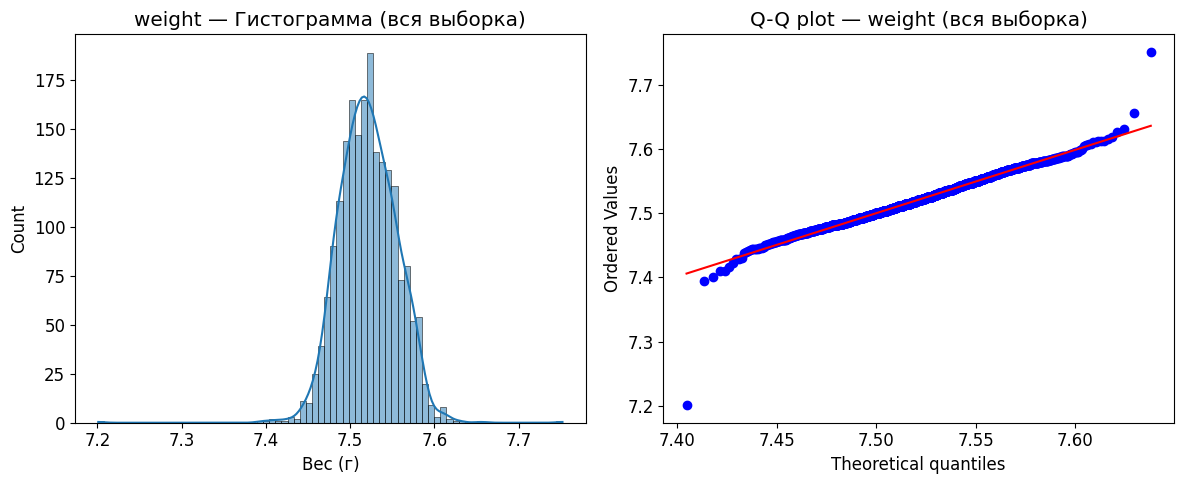

=== По batch'ам ===
Batch 1: N=250, mean=7.51966, sd=0.03436
Shapiro-Wilk: statistic = 0.9955 , p-value = 0.683002
KS (fitted): statistic = 0.0385 , p-value = 0.838962
CI mean = (7.515375800837306, 7.523936199162694)
CI sigma = (0.03159021367696744, 0.03766949188470649) 

Batch 2: N=250, mean=7.52317, sd=0.03549
Shapiro-Wilk: statistic = 0.9909 , p-value = 0.121877
KS (fitted): statistic = 0.0327 , p-value = 0.944481
CI mean = (7.518747761295764, 7.527588238704238)
CI sigma = (0.03262378217984407, 0.03890196219116049) 

Batch 3: N=250, mean=7.50954, sd=0.03704
Shapiro-Wilk: statistic = 0.8634 , p-value = 0.0
KS (fitted): statistic = 0.0779 , p-value = 0.091051
CI mean = (7.504930027624747, 7.514157972375253)
CI sigma = (0.03405364276136988, 0.040606987745049644) 

Batch 4: N=250, mean=7.53110, sd=0.02942
Shapiro-Wilk: statistic = 0.9955 , p-value = 0.682659
KS (fitted): statistic = 0.0454 , p-value = 0.662822
CI mean = (7.5274397498218875, 7.534768250178113)
CI sigma = (0.0270441728743

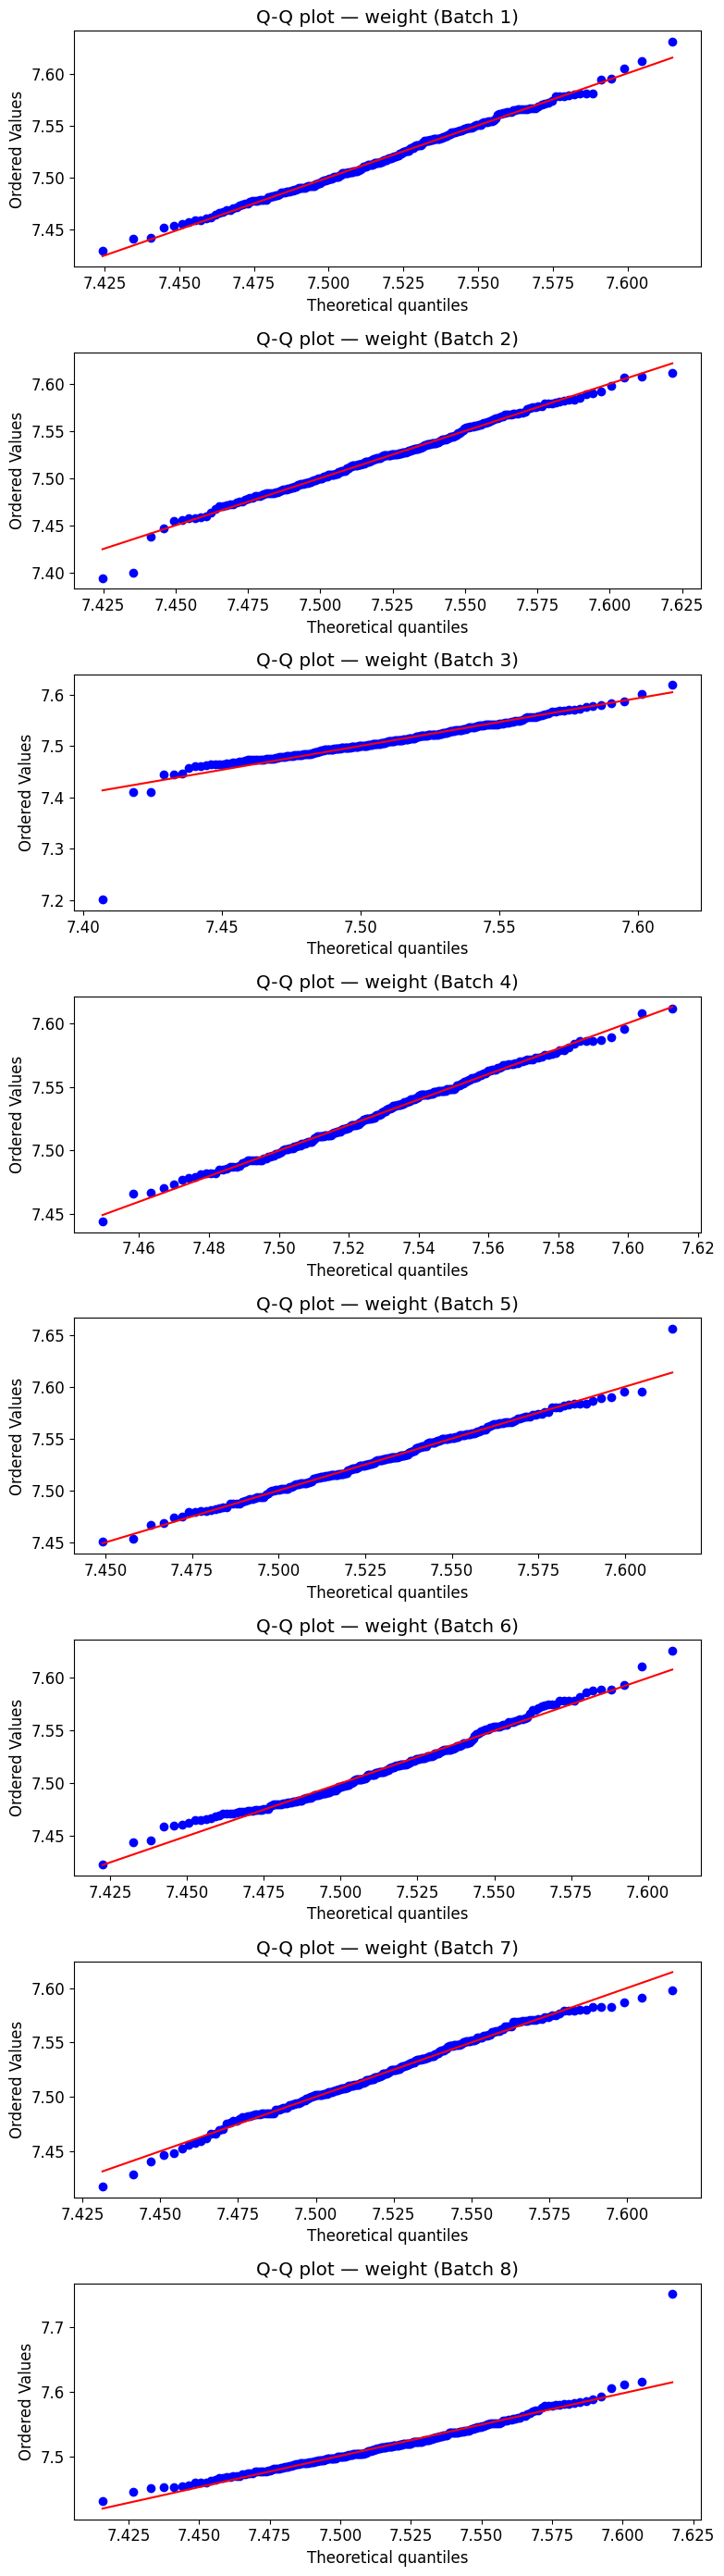

In [13]:
# Все монеты вместе
weightAllSeries = euroweightDataFrame['weight'].dropna()
print('\n=== Все монеты вместе ===')
print('N =', weightAllSeries.size, 'Mean =', weightAllSeries.mean(), 'SD =', weightAllSeries.std(ddof=1))

shapAllStat, shapAllP = sps.shapiro(weightAllSeries)
print('Shapiro-Wilk: statistic =', round(shapAllStat,4), ', p-value =', round(shapAllP,6))
ksAllStat, ksAllP = sps.kstest(weightAllSeries, 'norm', args=(weightAllSeries.mean(), weightAllSeries.std(ddof=1)))
print('KS (fitted): statistic =', round(ksAllStat,4), ', p-value =', round(ksAllP,6), '\n')

print('Доверительные интервалы (95%) для всех монет:')
print('CI mean =', confidenceIntervalForMean(weightAllSeries, 0.95))
print('CI sigma =', confidenceIntervalForSigma(weightAllSeries, 0.95))

figAll, axesAll = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма для всех
sns.histplot(weightAllSeries, kde=True, ax=axesAll[0])
axesAll[0].set_title('weight — Гистограмма (вся выборка)')
axesAll[0].set_xlabel('Вес (г)')

# Q-Q для всех
sps.probplot(weightAllSeries, dist='norm', sparams=(weightAllSeries.mean(), weightAllSeries.std(ddof=1)), plot=axesAll[1])
axesAll[1].set_title('Q-Q plot — weight (вся выборка)')

plt.tight_layout()
plt.show()

# По batch'ам
print('=== По batch\'ам ===')
figBatch, axesBatch = plt.subplots(8, 1, figsize=(8, 28))

for i, (batchId, batchGroup) in enumerate(euroweightDataFrame.groupby('batch')):
    batchWeights = batchGroup['weight'].dropna()
    print(f'Batch {batchId}: N={batchWeights.size}, mean={batchWeights.mean():.5f}, sd={batchWeights.std(ddof=1):.5f}')
    
    shStat, shP = sps.shapiro(batchWeights)
    ksStat, ksP = sps.kstest(batchWeights, 'norm', args=(batchWeights.mean(), batchWeights.std(ddof=1)))
    print('Shapiro-Wilk: statistic =', round(shStat,4), ', p-value =', round(shP,6))
    print('KS (fitted): statistic =', round(ksStat,4), ', p-value =', round(ksP,6))

    print('CI mean =', confidenceIntervalForMean(batchWeights, 0.95))
    print('CI sigma =', confidenceIntervalForSigma(batchWeights, 0.95), '\n')
    
    # Q-Q plot на i-й оси
    sps.probplot(batchWeights, dist='norm', sparams=(batchWeights.mean(), batchWeights.std(ddof=1)), plot=axesBatch[i])
    axesBatch[i].set_title(f'Q-Q plot — weight (Batch {batchId})')

plt.tight_layout()
plt.show()


# Dataset “iris.txt”

- Проверьте нормальность petal length по классам (setosa, versicolor, virginica). Используйте точечные оценки параметров.
- Постройте доверительные интервалы для μ и σ по классам.

In [11]:
irisDataFrame = pd.read_csv('../datasets/iris.txt', header=None, names=['sepalLength','sepalWidth','petalLength','petalWidth','class'])
irisDataFrame['petalLength'] = pd.to_numeric(irisDataFrame['petalLength'], errors='coerce')
print('Размер iris:', len(irisDataFrame))
print(irisDataFrame['class'].unique())

Размер iris: 150
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']



=== Iris-setosa ===
N = 50 Mean = 1.464 SD = 0.17351115943644546
Shapiro-Wilk: statistic = 0.9549 , p-value = 0.05465
KS (fitted): statistic = 0.1578 , p-value = 0.148617
CI mean = (1.414688674094744, 1.513311325905256)
CI sigma = (0.1449397726456133, 0.2162180441236967)

=== Iris-versicolor ===
N = 50 Mean = 4.26 SD = 0.46991097723995795
Shapiro-Wilk: statistic = 0.966 , p-value = 0.158478
KS (fitted): statistic = 0.1171 , p-value = 0.464242
CI mean = (4.126452777905478, 4.393547222094521)
CI sigma = (0.3925326211066252, 0.5855717450167487)

=== Iris-virginica ===
N = 50 Mean = 5.5520000000000005 SD = 0.5518946956639834
Shapiro-Wilk: statistic = 0.9622 , p-value = 0.109775
KS (fitted): statistic = 0.1136 , p-value = 0.502872
CI mean = (5.395153262927524, 5.708846737072477)
CI sigma = (0.4610164093979061, 0.6877343915301193)


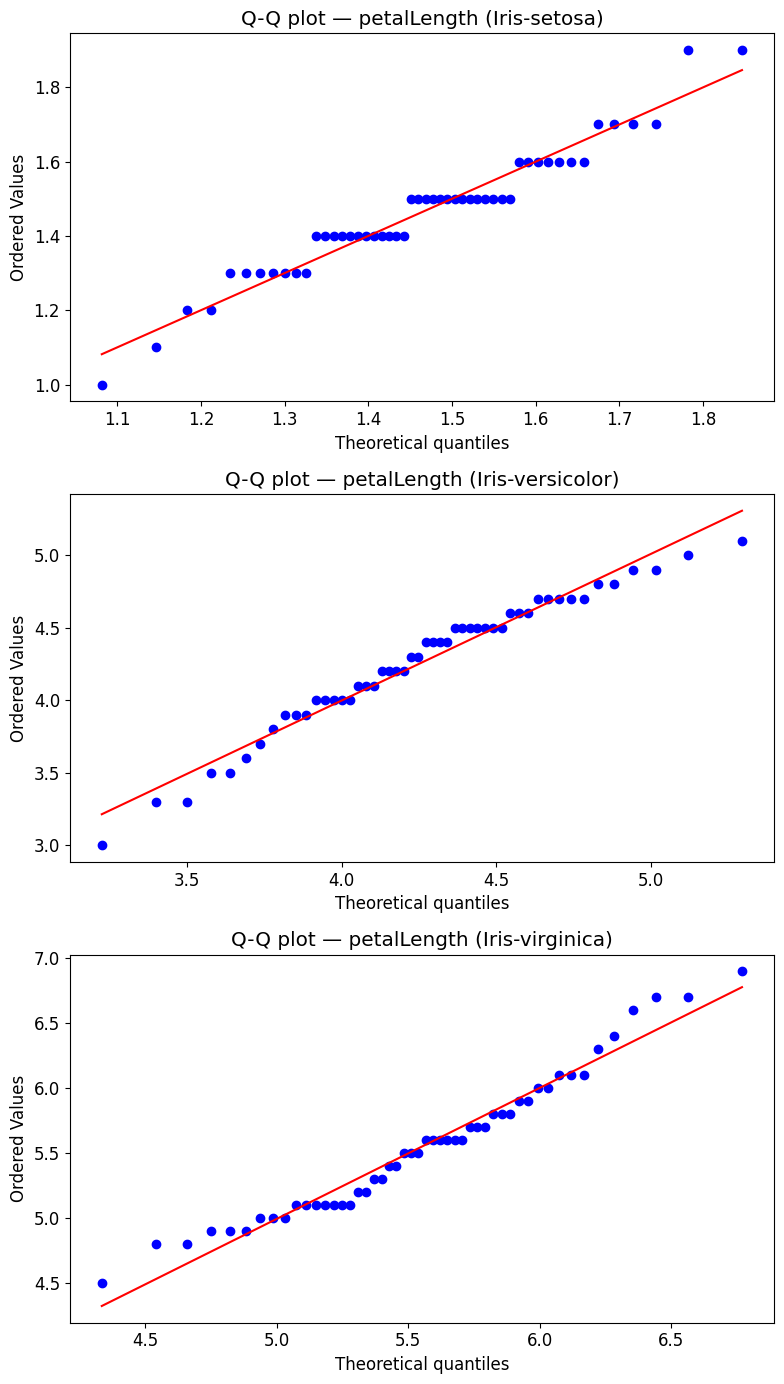

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(8, 14))

# Для каждой группы проверим нормальность petalLength
for i, (irisClass, groupFrame) in enumerate(irisDataFrame.groupby('class')):
    petalSeries = groupFrame['petalLength'].dropna()
    nGroup = petalSeries.size
    print(f'\n=== {irisClass} ===')
    print('N =', nGroup, 'Mean =', petalSeries.mean(), 'SD =', petalSeries.std(ddof=1))

    shStat, shP = sps.shapiro(petalSeries)
    ksStat, ksP = sps.kstest(petalSeries, 'norm', args=(petalSeries.mean(), petalSeries.std(ddof=1)))
    print('Shapiro-Wilk: statistic =', round(shStat,4), ', p-value =', round(shP,6))
    print('KS (fitted): statistic =', round(ksStat,4), ', p-value =', round(ksP,6))

    print('CI mean =', confidenceIntervalForMean(petalSeries, 0.95))
    print('CI sigma =', confidenceIntervalForSigma(petalSeries, 0.95))
    
    sps.probplot(petalSeries, dist='norm', sparams=(petalSeries.mean(), petalSeries.std(ddof=1)), plot=axes[i])
    axes[i].set_title(f'Q-Q plot — petalLength ({irisClass})')

plt.tight_layout()
plt.show()